In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [4]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


In [5]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [6]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


In [7]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


In [8]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


In [9]:

class NetLSTMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim / 2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim / 2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)))
        lstm_out, _ = self.lstmLayer(attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim / 2)),
                  torch.zeros(1, 1, int(self.hidden_dim / 2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # LSTM processing
                out, h0 = self.lstmLayer(attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetLSTMWithAttention(hidden_dim=12)


In [10]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


In [11]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


In [12]:
class NetGRUMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # GRU processing
                out, h0 = self.gruLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


In [26]:
def generateTrainData(num_samples, min_max):
    s = []  # Sequences
    t = []  # Labels
    params = {
    "min_length": min_max[0],
    "max_length": min_max[1],
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        #value_1 = -1
        #value_2 = 1
        if value_C == params["value_1"]: # XOR
            result = int(mapped_value_A != mapped_value_B) 
        else : # XNOR
            result =  int(mapped_value_A == mapped_value_B)

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR= params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, results_XORNOR]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [31]:
num_seq = 1
# Example dictionary with parameters
sequences, labels = generateTrainData(num_seq, [5,10])
print(sequences)
print(labels)

[array([[ 0,  0,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  1],
       [ 0,  0,  1]])]
[[-1  1 -1]]


In [21]:

sequences, labels = generateTrainData(1, [10,10])
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

tensor([[[ 0., -1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0., -1.],
         [ 0.,  0., -1.]]])
torch.Size([1, 3])
NetRNN(
  (expand_layer): Linear(in_features=3, out_features=12, bias=True)
  (rnnLayer): RNN(12, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_13062/667699806.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


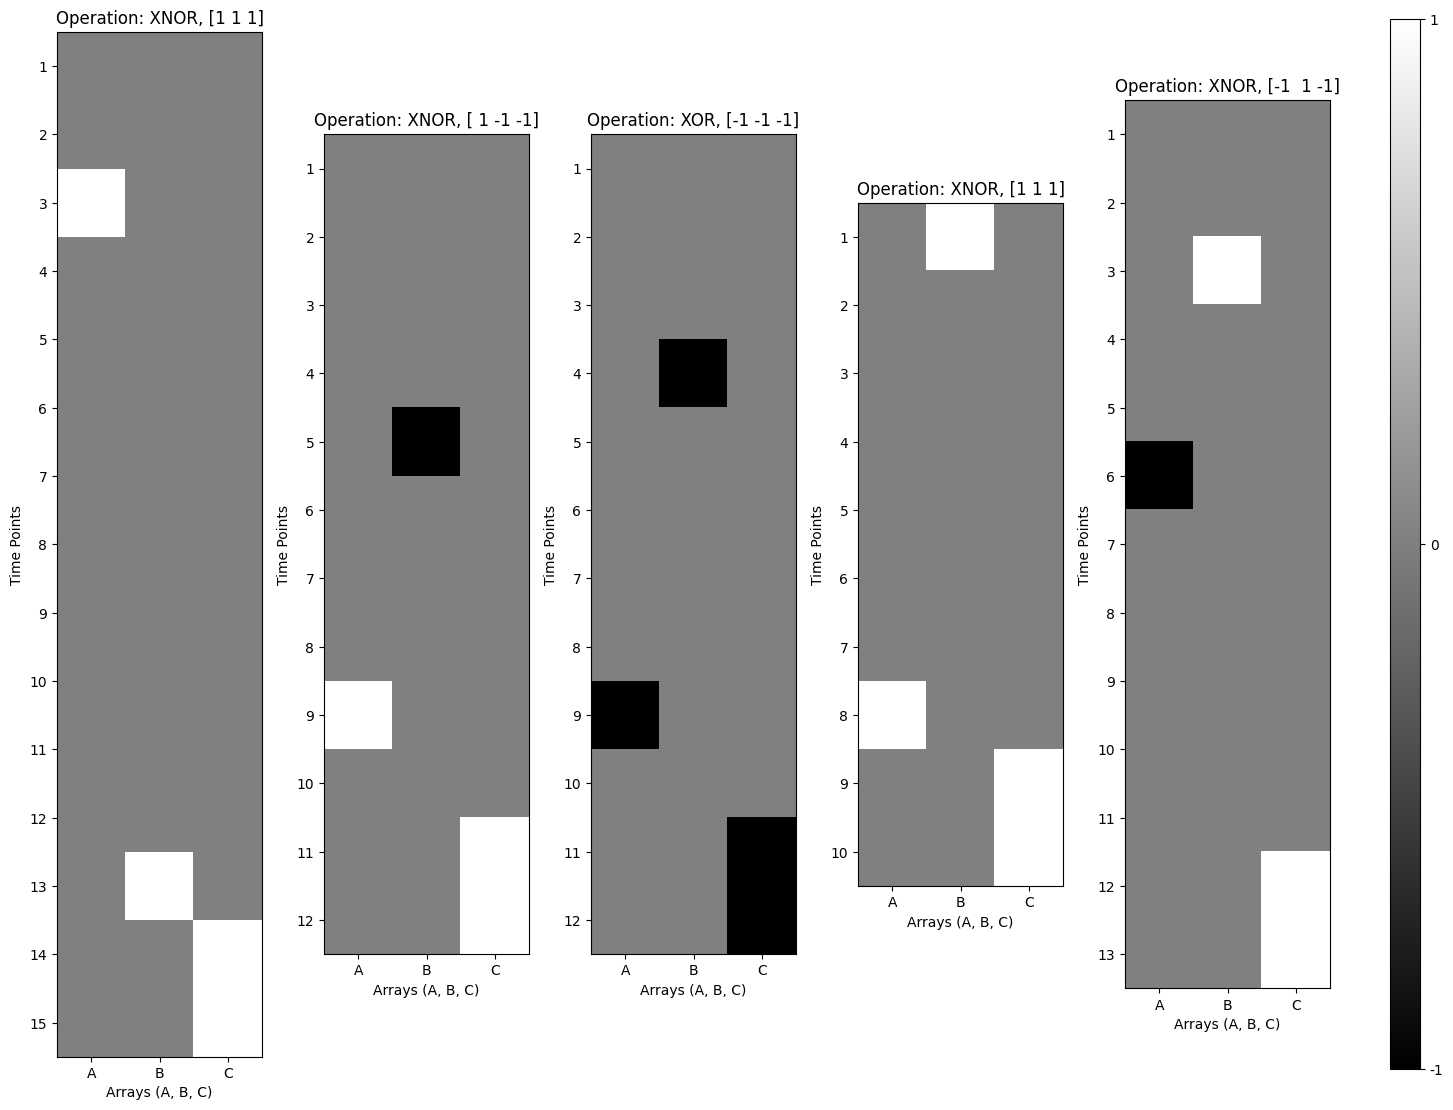

In [44]:

sequences, labels = generateTrainData(5, [10,15])

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax
        operation_title = "XOR" if seq[-1][2] == -1 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [46]:
parameters_list = []

# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [10]
max_lengths = [10]


In [48]:
collectorA = dict()
num_samples = 100
for rep in range(1):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        for kind in ["RNN", "NetRNNWithAttention", "NetRNNWithAttentionExpFirst","LSTM", "NetLSTMWithAttention","NetLSTMWithAttentionExpFirst" "GRU", "NetGRUWithAttention","NetGRUWithAttentionExpFirst"]:
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "NetRNNWithAttention":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetRNNWithAttentionExpFirst":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "NetLSTMWithAttention":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetLSTMWithAttentionExpFirst":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "NetGRUWithAttention":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetGRUWithAttentionExpFirst":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, [min_len,max_len])
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97:
                    break

            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA[f"{kind} {rep}"] = A
            torch.save(model, f'models/model_{kind}_min_{min_len}_max_{max_len}.model')
            print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")

RNN, rep: 0, epoch: 1, acc: 0.5166668891906738, Loss 1.0316485649347304
RNN, rep: 0, epoch: 2, acc: 0.5033334493637085, Loss 0.9972974008321762
RNN, rep: 0, epoch: 3, acc: 0.489999920129776, Loss 1.0031666266918182
RNN, rep: 0, epoch: 4, acc: 0.5233335494995117, Loss 0.9864435297250748
RNN, rep: 0, epoch: 5, acc: 0.6200001239776611, Loss 0.870319539308548
RNN, rep: 0, epoch: 6, acc: 0.6500001549720764, Loss 0.7463279914855957
RNN, rep: 0, epoch: 7, acc: 0.6866667866706848, Loss 0.6975022983551026
RNN, rep: 0, epoch: 8, acc: 0.6800001263618469, Loss 0.6844708108901978
RNN, rep: 0, epoch: 9, acc: 0.6800001263618469, Loss 0.6703288993239402
RNN, rep: 0, epoch: 10, acc: 0.836666464805603, Loss 0.5865707293152809
RNN, rep: 0, epoch: 11, acc: 0.8799999356269836, Loss 0.4316850689053535
RNN, rep: 0, epoch: 12, acc: 0.8799999356269836, Loss 0.37920360401272774
RNN, rep: 0, epoch: 13, acc: 0.8766665458679199, Loss 0.3503385777771473
RNN, rep: 0, epoch: 14, acc: 0.9399999976158142, Loss 0.324866

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NetRNNWithAttention, rep: 0, epoch: 1, acc: 0.51666659116745, Loss 1.0278711986541749
NetRNNWithAttention, rep: 0, epoch: 2, acc: 0.5199999809265137, Loss 0.9940285623073578
NetRNNWithAttention, rep: 0, epoch: 3, acc: 0.56333327293396, Loss 0.9660739779472352
NetRNNWithAttention, rep: 0, epoch: 4, acc: 0.6433334350585938, Loss 0.8487627819180489
NetRNNWithAttention, rep: 0, epoch: 5, acc: 0.6933332085609436, Loss 0.6860228902101517
NetRNNWithAttention, rep: 0, epoch: 6, acc: 0.6766665577888489, Loss 0.6779774779081345
NetRNNWithAttention, rep: 0, epoch: 7, acc: 0.6866664886474609, Loss 0.6647329294681549
NetRNNWithAttention, rep: 0, epoch: 8, acc: 0.68666672706604, Loss 0.6519290456175804
NetRNNWithAttention, rep: 0, epoch: 9, acc: 0.7933333516120911, Loss 0.6330175048112869
NetRNNWithAttention, rep: 0, epoch: 10, acc: 0.7800000905990601, Loss 0.5864713090658188
NetRNNWithAttention, rep: 0, epoch: 11, acc: 0.8299999833106995, Loss 0.4763231894373894
NetRNNWithAttention, rep: 0, epoch: 

In [120]:
# Load the model
model = torch.load("./models/model_RNN_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, [10,10])

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = 1.0 * (target_tensor.detach() > 0.0)
        B = 1.0 * (output.detach() > 0.0)
        acc = (1.0 * (A.flatten() == B.flatten())).mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 100.00%
Average Test Loss: 0.2346


In [116]:
# Load the model
model = torch.load("./models/model_NetRNNWithAttention_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode

# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, [10,10])

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = (target_tensor > 0.0).float()
        B = (output > 0.0).float()
        acc = (A.flatten() == B.flatten()).float().mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 87.00%
Average Test Loss: 0.4851


In [187]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::dsLength].transpose()
    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

Plot 0 - Min: 0.0, Max: 0.1915535868720526
Plot 1 - Min: 0.0, Max: 0.2718353557408144
Plot 2 - Min: 0.0, Max: 0.491915857397792
Plot 3 - Min: 0.0, Max: 0.5430941407286634
Plot 4 - Min: -8.881784197001252e-16, Max: 0.7111105930601576
Plot 5 - Min: -8.881784197001252e-16, Max: 0.8649494206765391
Plot 6 - Min: 0.0, Max: 0.9927008432395263
Plot 7 - Min: 0.0, Max: 0.99518107231264
Plot 8 - Min: 0.0, Max: 0.999708526033332
Plot 9 - Min: -4.440892098500626e-16, Max: 1.0000000000000004


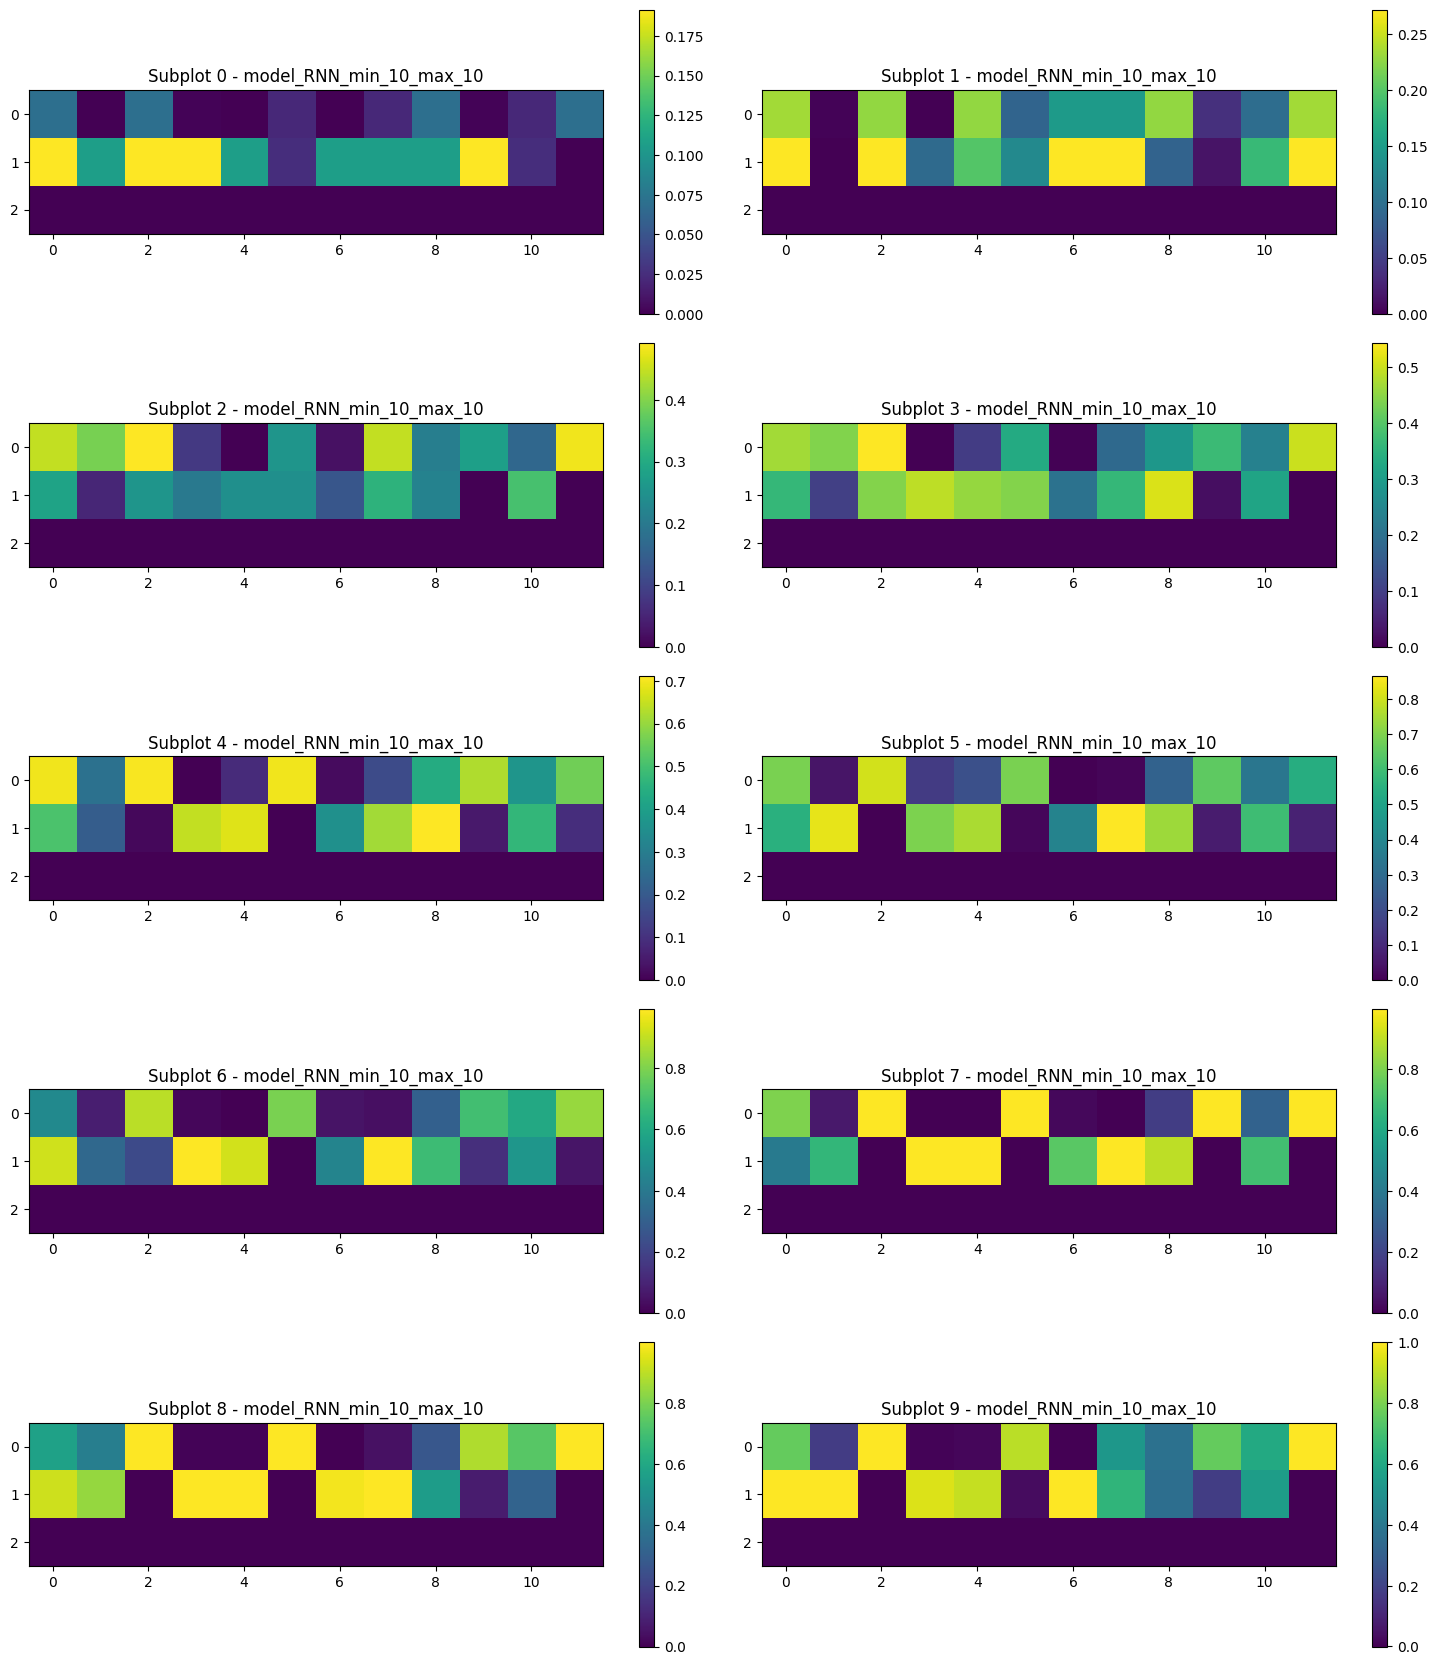

In [177]:
# Load the model
model = torch.load("./Models/model_RNN_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, [10,10])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_RNN_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show()    

Plot 0 - Min: -0.00412419859617108, Max: 0.12342955917609633
Plot 1 - Min: -0.05545756070733443, Max: 0.19406118408991047
Plot 2 - Min: -0.0041045522785774224, Max: 0.1547011248920791
Plot 3 - Min: 0.0, Max: 0.34275929093326063
Plot 4 - Min: -8.881784197001252e-16, Max: 0.3471380235063579
Plot 5 - Min: -0.01908528776743701, Max: 0.331392854696027
Plot 6 - Min: -0.004801664630723401, Max: 0.3450652046554956
Plot 7 - Min: -0.006317411410126539, Max: 0.5313588518629562
Plot 8 - Min: 0.0, Max: 0.34987723295933826
Plot 9 - Min: 0.0, Max: 0.33045341025887076


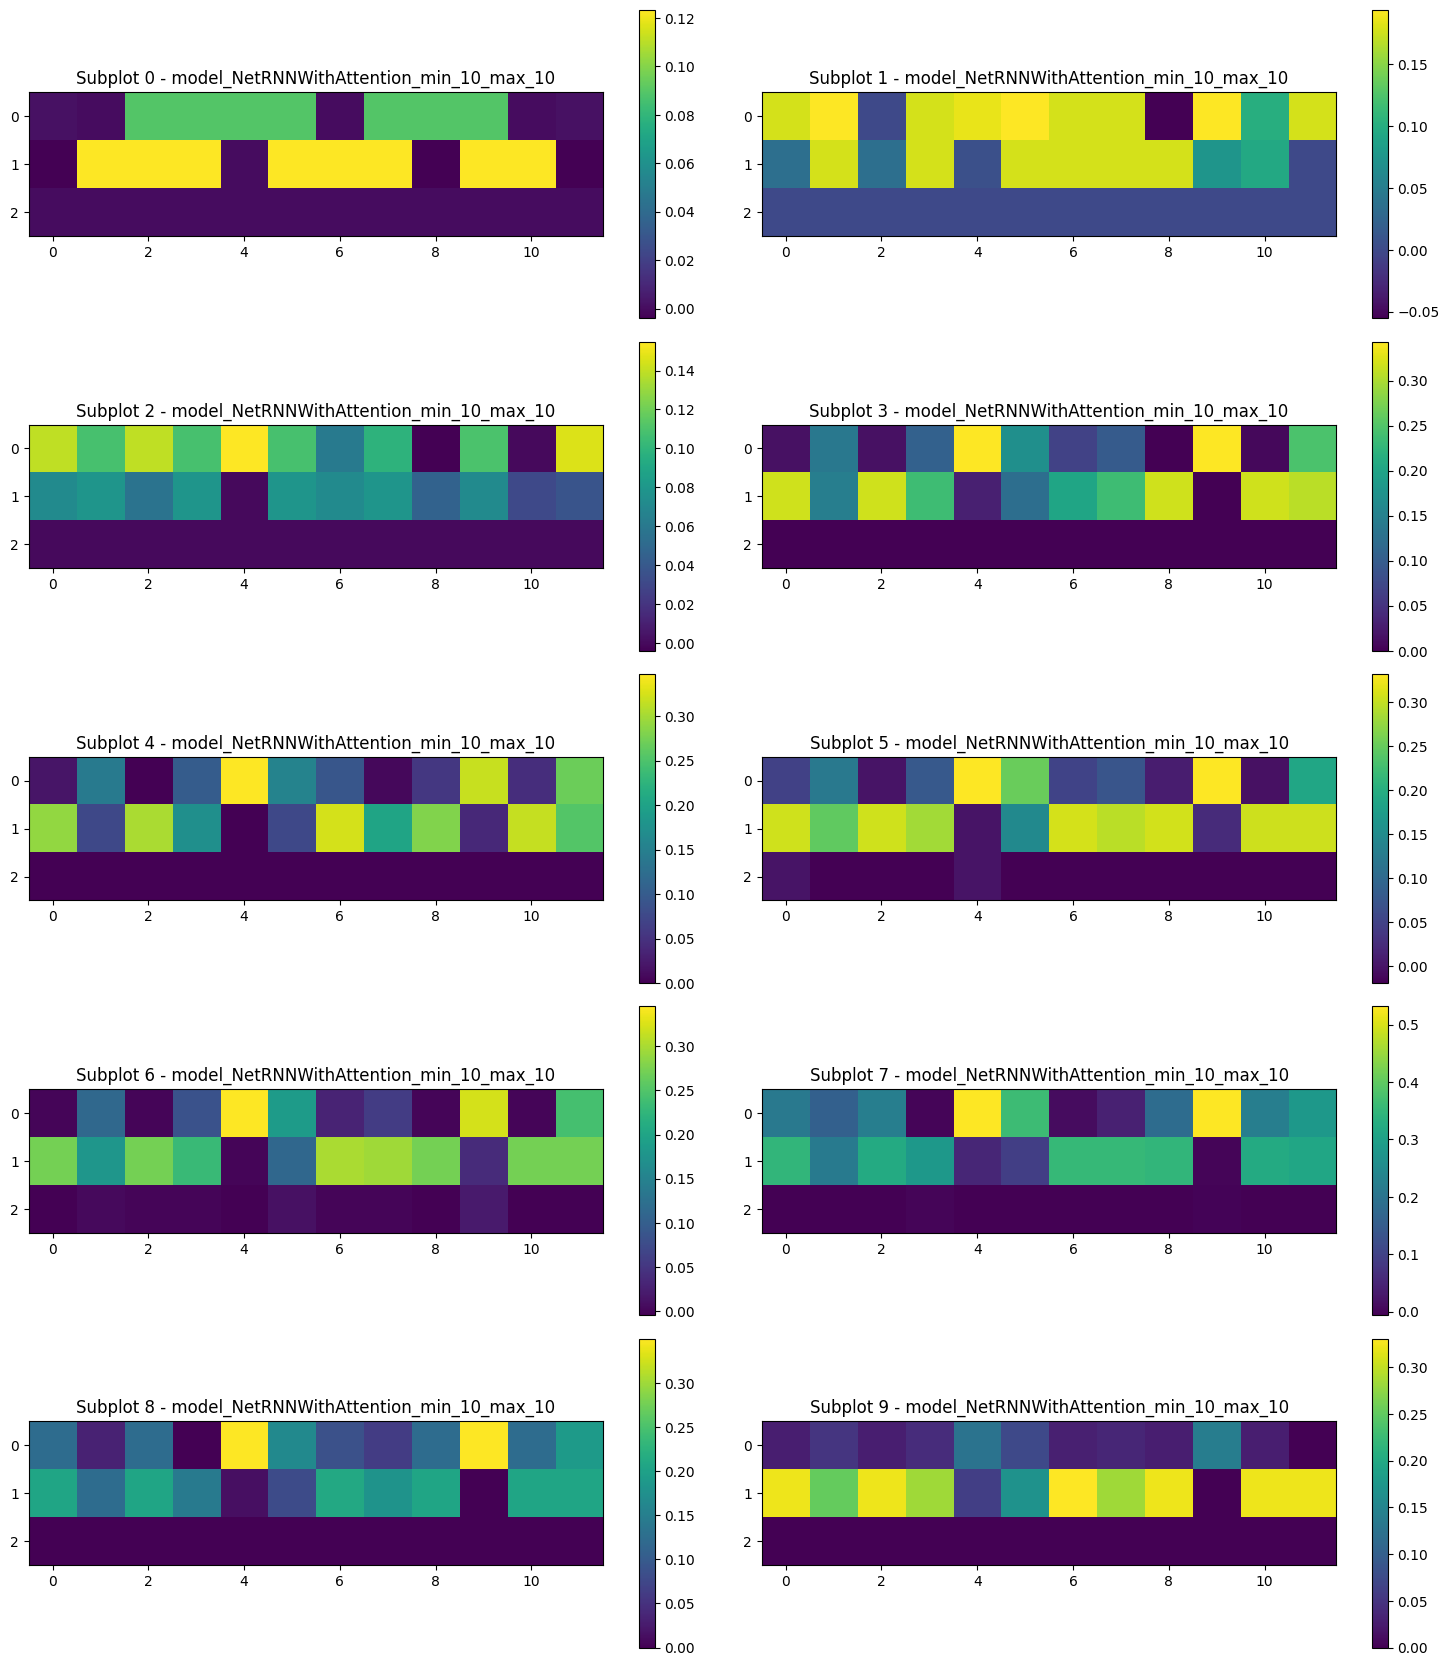

In [178]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttention_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, [10,10])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_NetRNNWithAttention_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show()    

Plot 0 - Min: -0.0028880970083648982, Max: 0.04589103108812109
Plot 1 - Min: 0.0, Max: 0.1359353001172945
Plot 2 - Min: -0.023212730699955664, Max: 0.3183022026958753
Plot 3 - Min: -0.0036997090113519704, Max: 0.26641105688893063
Plot 4 - Min: -0.019360885473082234, Max: 0.2886009535946874
Plot 5 - Min: -0.007113939390851698, Max: 0.29981526303204564
Plot 6 - Min: -0.0056403387948544825, Max: 0.2503822767045394
Plot 7 - Min: -0.01782814761023932, Max: 0.3471101609458698
Plot 8 - Min: -0.025949989447269672, Max: 0.24838951363534267
Plot 9 - Min: -0.023903114054736108, Max: 0.20737076985156477


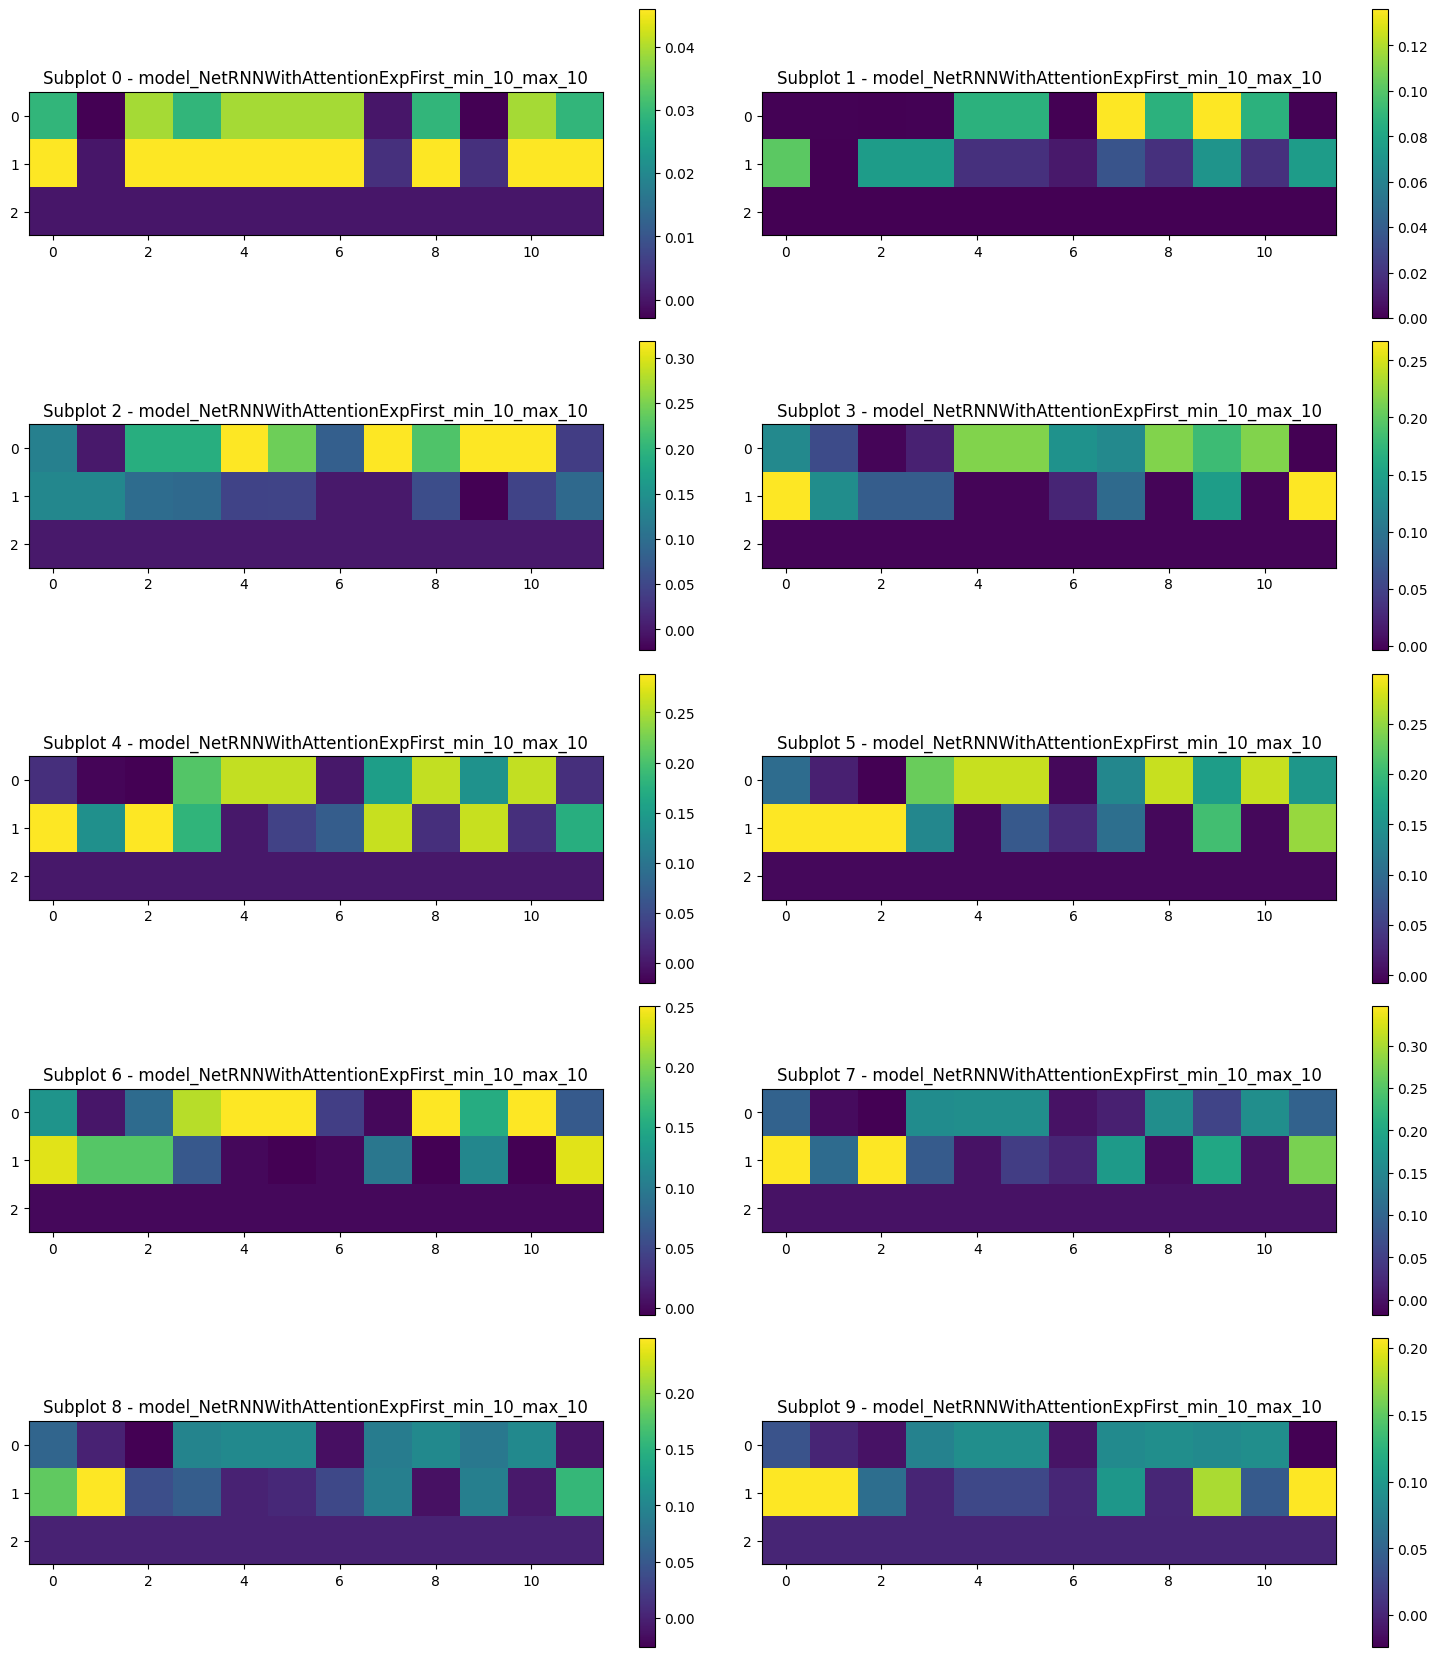

In [188]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttentionExpFirst_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, [10,10])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_NetRNNWithAttentionExpFirst_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show()    

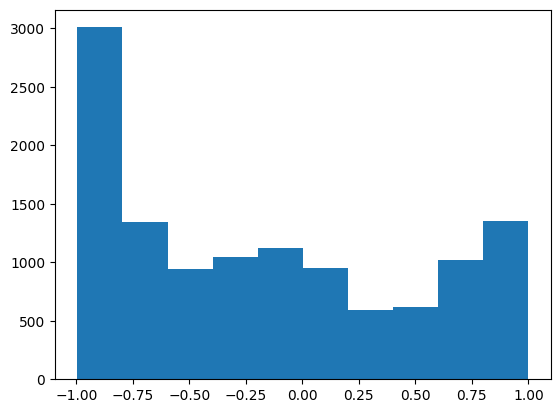

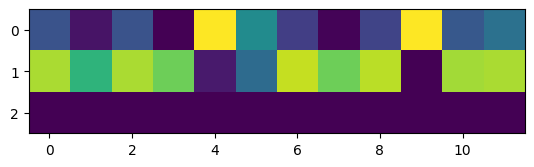

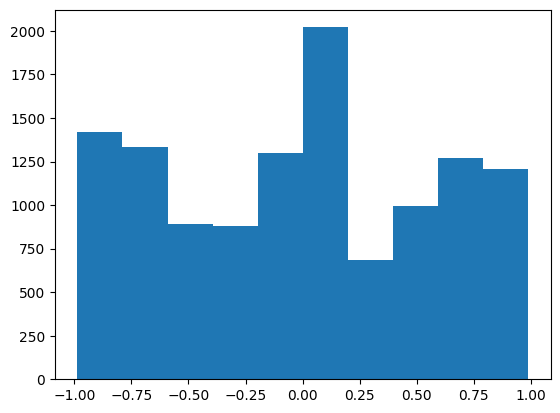

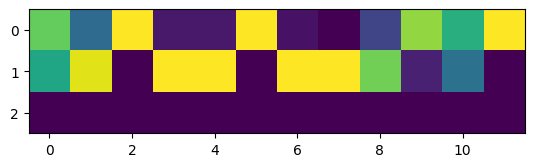

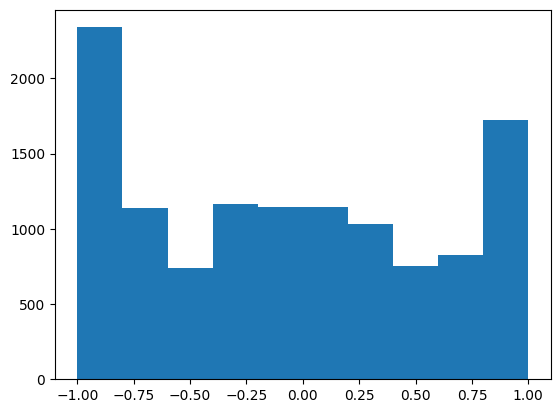

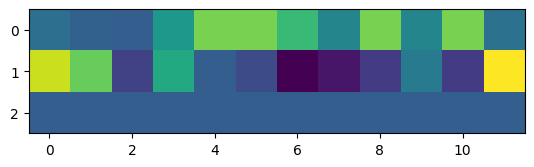

In [185]:

modelRNNWithAttention=torch.load("models/model_RNN_min_10_max_10.model")
modelRNN=torch.load("models/model_NetRNNWithAttention_min_10_max_10.model")
modelRNNWithAttentionExp =torch.load("models/model_NetRNNWithAttentionExpFirst_min_10_max_10.model")
s,t = generateTrainData(100, [10,10])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))